<a href="https://colab.research.google.com/github/Kogo0813/Windroad8/blob/main/TPUver_windpredict_data_from_s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!echo $COLAB_TPU_ADDR #코랩에서 런타임->런타임 유형 변경 -> TPU로 변경

10.89.216.42:8470


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from osgeo import gdal

# TPU gRPC 접근 URI
TPU_PATH = f"grpc://{os.environ['COLAB_TPU_ADDR']}"
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_PATH)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [3]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive
%cd MyDrive
%cd data_from_s

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/data_from_s


In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, Flatten
import tensorflow.keras.backend as K
from keras.utils import get_custom_objects
with strategy.scope():
  def r2_metric(y_true, y_pred):
      SS_res =  K.sum(K.square(y_true - y_pred))
      SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
      return (1 - SS_res/(SS_tot + K.epsilon()))

  get_custom_objects().update({'r2_metric': r2_metric})
  width = 75
  height = 60
  channels = 5
  model = Sequential([
      keras.Input(shape=(None,height,width,channels)),
        layers.ConvLSTM2D(filters=16 , kernel_size=(3, 3), padding="same", return_sequences=True),
         layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True),
         layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True),
         layers.ConvLSTM2D(filters=2, kernel_size=(3, 3), padding="same", return_sequences=False),
  ])
  # 모델 컴파일
  model.compile(optimizer='adam', loss='mse',metrics='r2_metric')
  model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_37 (ConvLSTM2D)  (None, None, 60, 75, 16)  12160    
                                                                 
 conv_lstm2d_38 (ConvLSTM2D)  (None, None, 60, 75, 32)  55424    
                                                                 
 conv_lstm2d_39 (ConvLSTM2D)  (None, None, 60, 75, 64)  221440   
                                                                 
 conv_lstm2d_40 (ConvLSTM2D)  (None, 60, 75, 2)        4760      
                                                                 
Total params: 293,784
Trainable params: 293,784
Non-trainable params: 0
_________________________________________________________________


In [42]:
#from skimage.measure import block_reduce 다운샘플링보다 잘라쓰는게 나을것 같에서 중간에이미지 잘라서 썻습니다.
#이거 돌아가는데 약 3시간 30분 걸립니다 참고하세요
from sklearn.preprocessing import MinMaxScaler # 입력 정규화 Min-Max 스케일링 사용


X = []
Y = []
for i in range(1, 3):
  for h in range(1, 4):
    for s in range(0,6):
      for d in range(0, 360, 60):
        if i==3 and h==1 and s ==3 : 
          continue
        if i==3 and h==3 and s ==1 and d==300: 
          continue
        if i==3 and h==3 and s ==5 and d==120: 
          continue
        if i==8 and h==1 and s ==3 and d==120: 
          continue
        if i==9 and h==2 and s ==3 and d==300: 
          continue ## 이 파일들 이상해서 그냥 안쓸려고 합니다.
        height = np.full((60,75),h) 
        speed = np.full((60,75), s)
        direction = np.full((60,75),d)
        uz_zero = np.full((60,75),0)
        vz_zero = np.full((60,75),0)
        scaler_3 = MinMaxScaler()
        area = scaler_3.fit_transform(height + speed + direction) # 3가지 파라미터 합친거
        scaler_terrain = MinMaxScaler()
        scaler_landuse = MinMaxScaler()
        landuse = gdal.Open("입력데이터/"+"Landuse_"+"{:006d}".format(i)+".tif")
        landuse = np.array(landuse.GetRasterBand(1).ReadAsArray())
        landuse = landuse[:60,:75]
        terrain = gdal.Open("입력데이터/"+"Terrain_"+"{:006d}".format(i)+".tif")
        terrain = np.array(terrain.GetRasterBand(1).ReadAsArray())
        terrain = terrain[:60,:75]
        terrain = scaler_terrain.fit_transform(terrain)
        landuse = scaler_landuse.fit_transform(landuse)
        stacked_layer_input = []
        stacked_layer_input.append(np.dstack((uz_zero,vz_zero,landuse,terrain,area)))
        scaler_z = MinMaxScaler()
        for j in range(360, 3960, 360):
            uz = np.loadtxt("0000" +"{:02d}".format(i) +"_R010_H0"+ str(h) +".0_S00"+str(s)+".00_D"+"{:003d}".format(d)+'_uz00'+"{:04d}".format(j)+'.dw', skiprows = 8, dtype = 'int', encoding='latin-1')
            vz = np.loadtxt("0000" +"{:02d}".format(i) +"_R010_H0"+ str(h) +".0_S00"+str(s)+".00_D"+"{:003d}".format(d)+'_vz00'+"{:04d}".format(j)+'.dw', skiprows = 8, dtype = 'int', encoding='latin-1')
            uz = uz[:60,:75]
            vz = vz[:60,:75]
            uz = scaler_z.fit_transform(uz)
            vz = scaler_z.fit_transform(vz)
            if j == 3600:
              stacked_layer_output = np.dstack((uz,vz))
            else:
              stacked_layer_input.append(np.dstack((uz,vz,landuse,terrain,area)))
        X.append(stacked_layer_input)
        Y.append(stacked_layer_output)


In [43]:
X = np.array(X)
Y = np.array(Y)

X.shape

(216, 10, 60, 75, 5)

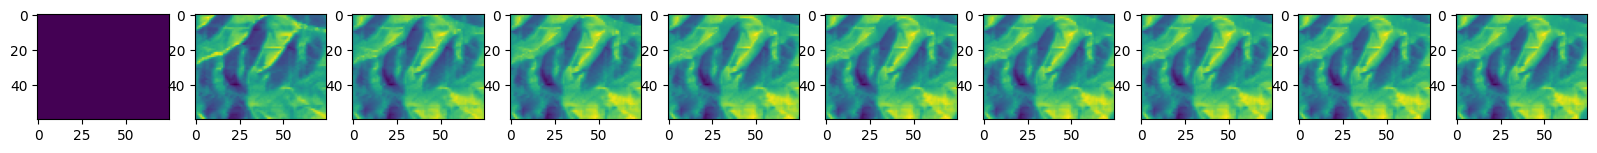

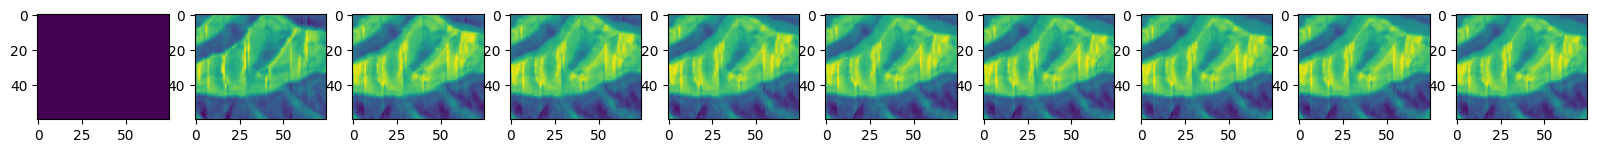

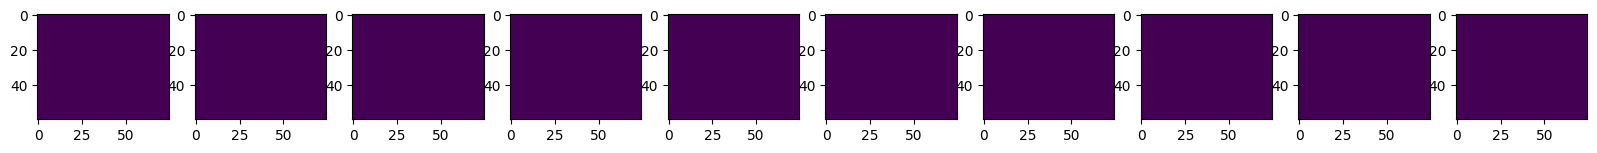

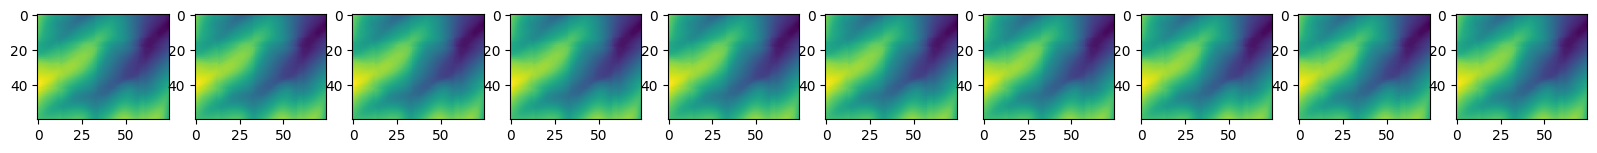

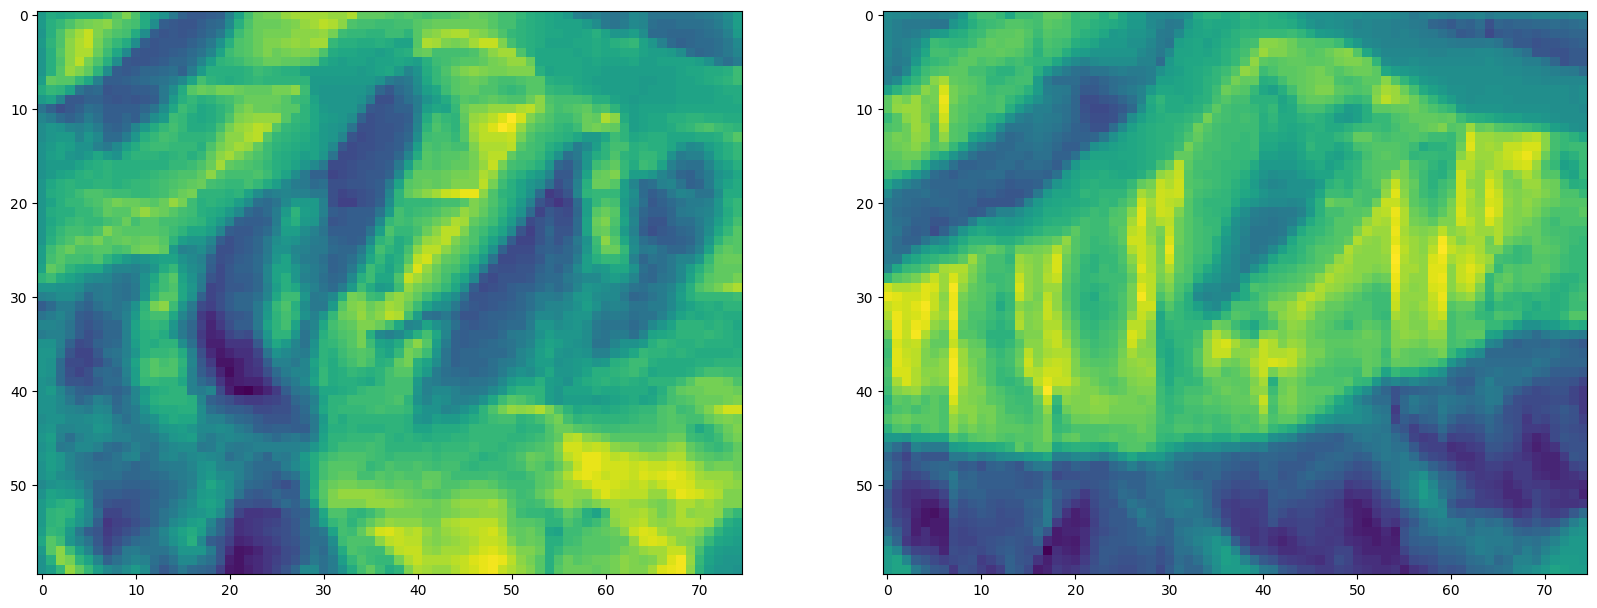

In [39]:
plt.figure(figsize=(20,30))  #잘라낸 이미지 360초 단위 9번 동안의 변화 시각화
for i in range(X.shape[1]): #uz
    plt.subplot(1,10,i+1)
    plt.imshow(X[4,i,:,:,0])
plt.show()
plt.figure(figsize=(20,30))  #잘라낸 이미지 360초 단위 9번 동안의 변화 시각화
for i in range(X.shape[1]): #vz
    plt.subplot(1,10,i+1)
    plt.imshow(X[4,i,:,:,1])
plt.show()
plt.figure(figsize=(20,30)) 
for i in range(X.shape[1]): #landuse
    plt.subplot(1,10,i+1)
    plt.imshow(X[4,i,:,:,2])
plt.show()
plt.figure(figsize=(20,30)) 
for i in range(X.shape[1]): #terrain
    plt.subplot(1,10,i+1)
    plt.imshow(X[4,i,:,:,3])
plt.show()
plt.figure(figsize=(20,30)) 

for i in range(2): #정답값이 되는 10번쨰 uz,vz
    plt.subplot(1,2,i+1)
    plt.imshow(Y[4,:,:,i])
plt.show()

In [101]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True)
with strategy.scope():
  early_stop = EarlyStopping(monitor='val_loss',min_delta=0.001, patience=3, verbose=1, mode='min',restore_best_weights=True)
  history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=400, callbacks=[early_stop])

Epoch 1/400
6/6 [==============================] - 99s 11s/step - loss: 0.1558 - r2_metric: -0.8193 - val_loss: 0.0775 - val_r2_metric: 0.0962
Epoch 2/400
6/6 [==============================] - 4s 757ms/step - loss: 0.0774 - r2_metric: 0.0709 - val_loss: 0.0704 - val_r2_metric: 0.1813
Epoch 3/400
6/6 [==============================] - 5s 836ms/step - loss: 0.0673 - r2_metric: 0.1941 - val_loss: 0.0500 - val_r2_metric: 0.4214
Epoch 4/400
6/6 [==============================] - 6s 993ms/step - loss: 0.0451 - r2_metric: 0.4565 - val_loss: 0.0407 - val_r2_metric: 0.5216
Epoch 5/400
6/6 [==============================] - 5s 849ms/step - loss: 0.0369 - r2_metric: 0.5534 - val_loss: 0.0312 - val_r2_metric: 0.6361
Epoch 6/400
6/6 [==============================] - 5s 839ms/step - loss: 0.0290 - r2_metric: 0.6545 - val_loss: 0.0230 - val_r2_metric: 0.7316
Epoch 7/400
6/6 [==============================] - 5s 914ms/step - loss: 0.0199 - r2_metric: 0.7618 - val_loss: 0.0163 - val_r2_metric: 0.8103

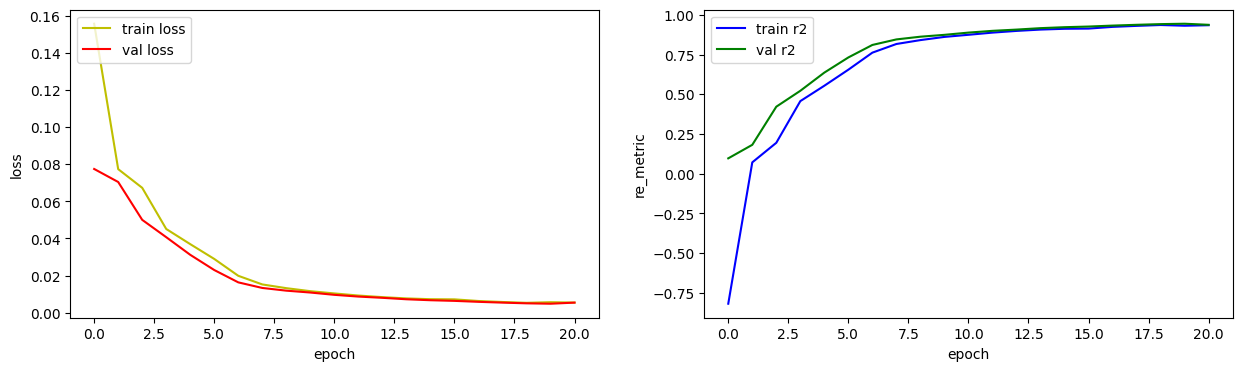

In [105]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

ax[0].plot(history.history['loss'],'y',label='train loss')
ax[0].plot(history.history['val_loss'],'r',label='val loss')
ax[1].plot(history.history['r2_metric'],'b',label='train r2')
ax[1].plot(history.history['val_r2_metric'],'g',label='val r2')

ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

ax[1].set_xlabel('epoch')
ax[1].set_ylabel('re_metric')

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
plt.show()

In [103]:
sample = x_val[0].reshape(1,10,60,75,5)
with strategy.scope():
  predictions = model.predict(sample)

1/1 [==============================] - 13s 13s/step


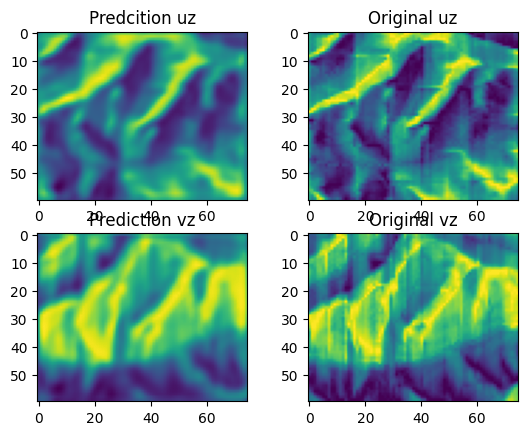

In [104]:
predictions = predictions.reshape(60,75,2)
fig, ax = plt.subplots(2, 2)

ax[0][0].imshow(predictions[:,:,0])
ax[0][0].set_title('Predcition uz')
ax[0][1].imshow(y_val[0,:,:,0])
ax[0][1].set_title('Original uz')
ax[1][0].imshow(predictions[:,:,1])
ax[1][0].set_title('Prediction vz')
ax[1][1].imshow(y_val[0,:,:,1])
ax[1][1].set_title('Original vz')

plt.show()

In [82]:
sample = x_val[0].reshape(1,10,60,75,5)
movie = []
new_landuse = x_val[0,0,:,:,2]
new_landuse = new_landuse.reshape(1,1,60,75,1)
new_terrain = x_val[0,0,:,:,3]
new_terrain = new_terrain.reshape(1,1,60,75,1)
new_area = x_val[0,0,:,:,4]
new_area = new_area.reshape(1,1,60,75,1)
with strategy.scope():
  for i in range(0,20):
    predictions = model.predict(sample)
    movie.append(predictions)
    prediction_uz = predictions[0,:,:,0]
    prediction_vz = predictions[0,:,:,1]
    prediction_uz = prediction_uz.reshape(1,1,60,75,1)
    prediction_vz = prediction_vz.reshape(1,1,60,75,1)
    new_image = np.concatenate((prediction_uz,prediction_vz, new_landuse, new_landuse, new_area), axis=4)
    sample = np.delete(sample, 0, axis=1)
    sample = np.concatenate((sample, new_image), axis=1)

1/1 [==============================] - 1s 691ms/step


In [94]:
movie = np.array(movie)
movie_uz = movie[:,0,:,:,0]
movie_vz = movie[:,0,:,:,1]
movie_uz = movie_uz.reshape(20,60,75,1)
print(movie_uz.shape)

(20, 60, 75, 1)


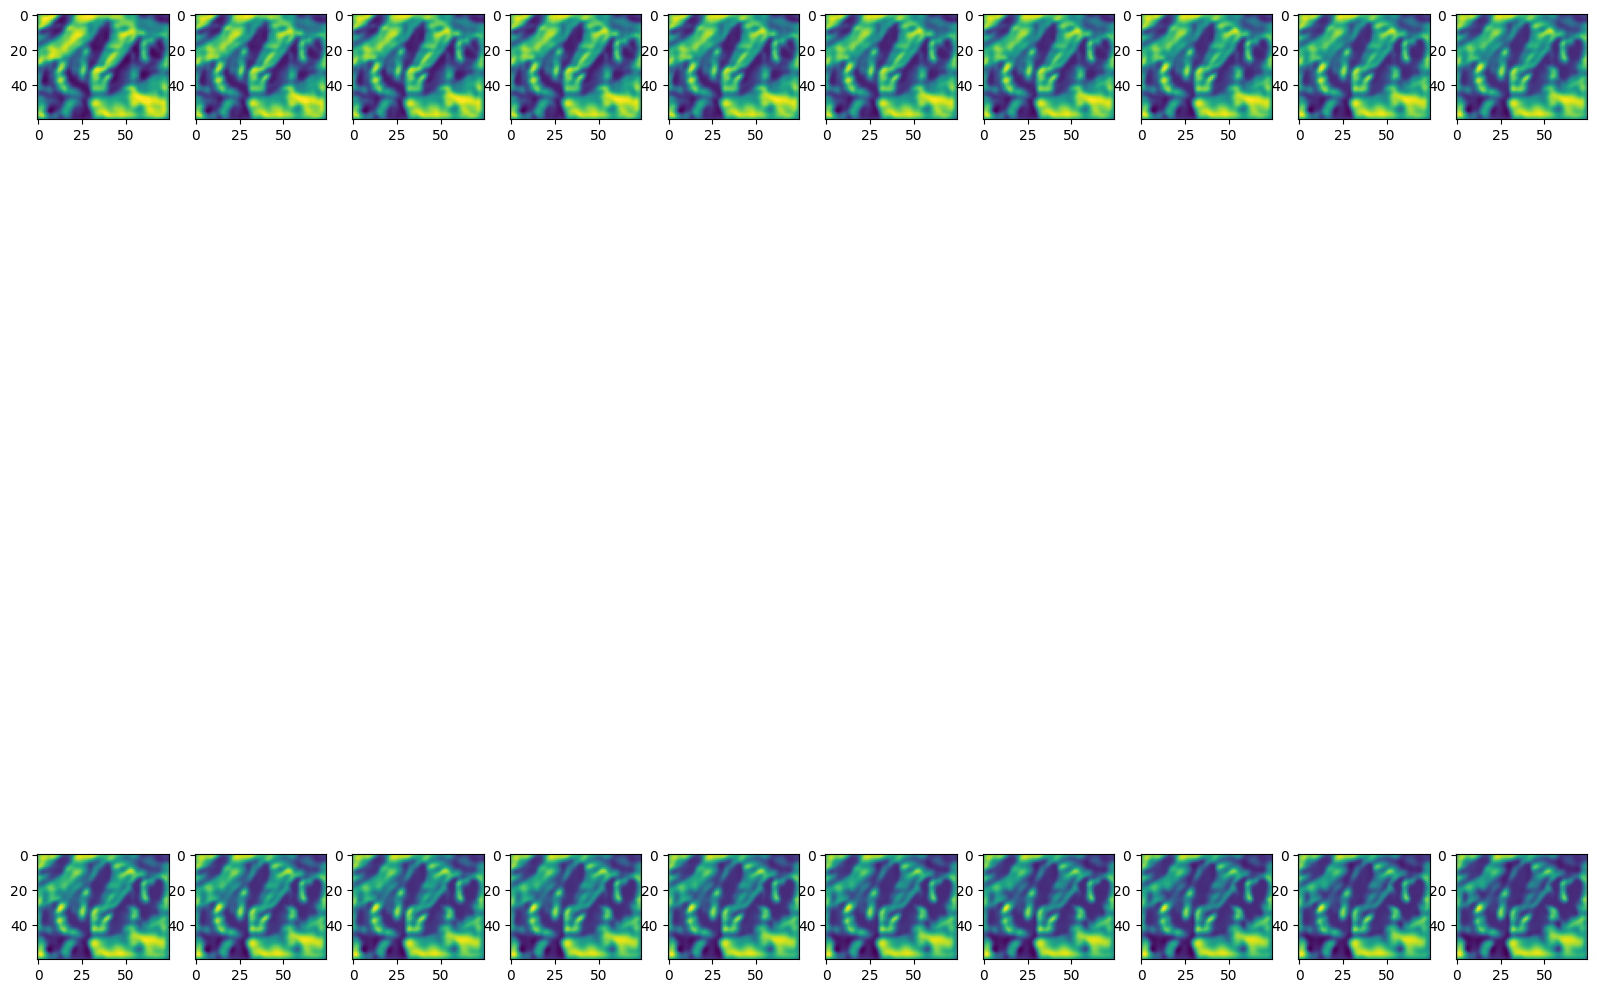

In [99]:
fig, ax = plt.subplots(2, 10, figsize = (20,20))
for i in range(0,2):
  for j in range(0,10):
    ax[i][j].imshow(movie_uz[i*10+j,:,:,0])